This script will take two fires from mtbs and try to use mighty mosaic on them to compare to EE, in hopes it will remove the tiling effect.  MightyMosaic docs: https://github.com/AurelienColin/MightyMosaic#introduction

In [1]:
from osgeo import gdal
import numpy as np
from keras.models import load_model
from keras import losses
import datetime
import math,os
import sys
import glob
import matplotlib.pyplot as plt
import rioxarray
import random
import tensorflow as tf

# from dataProcess import  color_dict

#  Read tif data set
def readTif(fileName, xoff = 0, yoff = 0, data_width = 0, data_height = 0):
    dataset = gdal.Open(fileName)
    if dataset == None:
        print(fileName + "file cannot be opened")
    #  Number of columns of raster matrix
    width = dataset.RasterXSize
    #  Number of rows of raster matrix
    height = dataset.RasterYSize
    #  Number of columns of raster matrix
    bands = dataset.RasterCount
    #  retrieve data
    if(data_width == 0 and data_height == 0):
        data_width = width
        data_height = height
    data = dataset.ReadAsArray(xoff, yoff, data_width, data_height)
    # Get affine matrix information
    geotrans = dataset.GetGeoTransform()
    # get projection info
    proj = dataset.GetProjection()
    return width, height, bands, data, geotrans, proj

#save tif file function
def writeTiff(im_data, im_geotrans, im_proj, path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape

    #create a fiile
    path_compress=path
    path=path.replace('.tif','orig.tif')
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #Write affine transformation parameters
        dataset.SetProjection(im_proj) #write projection
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset
    compress(path,path_compress)

def compress(path, target_path,method="LZW"): #
    """Using gdal for file compression,
          The LZW method is lossless compression and has better black and white image effects.
          """
    dataset = gdal.Open(path)
    driver = gdal.GetDriverByName('GTiff')
    driver.CreateCopy(target_path, dataset, strict=1, options=["TILED=YES", "COMPRESS={0}".format(method)])
    del dataset
    os.remove(path)
    

#  tif crop (tif pixel data, crop side length)
def TifCroppingArray(img, SideLength):
    #  Cut the linked list
    TifArrayReturn = []
    #  Number of image blocks on the column
    ColumnNum = int((img.shape[0] - SideLength * 2) / (128 - SideLength * 2))
    #  Number of image blocks on the line
    RowNum = int((img.shape[1] - SideLength * 2) / (128 - SideLength * 2))
    for i in range(ColumnNum):
        TifArray = []
        for j in range(RowNum):
            cropped = img[i * (128 - SideLength * 2) : i * (128 - SideLength * 2) + 128,
                          j * (128 - SideLength * 2) : j * (128 - SideLength * 2) + 128]
            TifArray.append(cropped)
        TifArrayReturn.append(TifArray)
    #  Considering that there will be remainders in the rows and columns, crop one row and one column forward.
    #  Crop last column forward
    for i in range(ColumnNum):
        cropped = img[i * (128 - SideLength * 2) : i * (128 - SideLength * 2) + 128,
                      (img.shape[1] - 128) : img.shape[1]]
        TifArrayReturn[i].append(cropped)
    #  Crop last row forward
    TifArray = []
    for j in range(RowNum):
        cropped = img[(img.shape[0] - 128) : img.shape[0],
                      j * (128-SideLength*2) : j * (128 - SideLength * 2) + 128]
        TifArray.append(cropped)
    #  Crop lower right corner forward
    cropped = img[(img.shape[0] - 128) : img.shape[0],
                  (img.shape[1] - 128) : img.shape[1]]
    TifArray.append(cropped)
    TifArrayReturn.append(TifArray)
    #  remaining number on column
    ColumnOver = (img.shape[0] - SideLength * 2) % (128 - SideLength * 2) + SideLength
    #  remaining number on the line
    RowOver = (img.shape[1] - SideLength * 2) % (128 - SideLength * 2) + SideLength
    return TifArrayReturn, RowOver, ColumnOver

#  Label visualization, that is, assigning n values to the nth category
def labelVisualize(img):
    img_out = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #  Assign n value to nth class
            img_out[i][j] = np.argmax(img[i][j])
    return img_out

#  Normalize the test image and make its dimensions consistent with the training image
def testGenerator(TifArray):

    for i in range(len(TifArray)):
        for j in range(len(TifArray[0])):
            img = TifArray[i][j]
            
            # img = img[:, :, :-1] #don't have labels
            #normalize
            # img = img / 255.0
            #reshape
            # img = np.reshape(img,(1,)+img.shape)
            img = np.expand_dims(img, axis=0)
            yield img
            
# Create a generator function
def generator(tif_files):
    for tif_file in tif_files:
        # img = load_and_preprocess_image(tif_file)  # Implement a function to load and preprocess your image
        img = np.expand_dims(tif_file, axis=0)  # Add batch dimension
        yield img


#  Get the result matrix
def Result(shape, TifArray, npyfile, num_class, RepetitiveLength, RowOver, ColumnOver):
    result = np.zeros(shape, np.float32)
    #  j to mark the number of rows
    j = 0
    for i,item in enumerate(npyfile):
        img = item[:, :, 0]
      
        #  Special consideration is given to the leftmost column. The left edge must be spliced ​​in.
        if(i % len(TifArray[0]) == 0):
            #  The first row needs special consideration, and the upper edge needs to be taken into account.
            if(j == 0):
                result[0 : 128 - RepetitiveLength, 0 : 128-RepetitiveLength] = img[0 : 128 - RepetitiveLength, 0 : 128 - RepetitiveLength]
            #  The last line needs special consideration, and the lower edge needs to be taken into account.
            elif(j == len(TifArray) - 1):
                #  It turned out to be wrong
                #result[shape[0] - ColumnOver : shape[0], 0 : 128 - RepetitiveLength] = img[0 : ColumnOver, 0 : 128 - RepetitiveLength]
                #  Modified later
                result[shape[0] - ColumnOver - RepetitiveLength: shape[0], 0 : 128 - RepetitiveLength] = img[128 - ColumnOver - RepetitiveLength : 128, 0 : 128 - RepetitiveLength]
            else:
                result[j * (128 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength,
                       0:128-RepetitiveLength] = img[RepetitiveLength : 128 - RepetitiveLength, 0 : 128 - RepetitiveLength]
        #  Special consideration is given to the rightmost column, the right edge should be spliced ​​in
        elif(i % len(TifArray[0]) == len(TifArray[0]) - 1):
            #  The first row needs special consideration, and the upper edge needs to be taken into account.
            if(j == 0):
                result[0 : 128 - RepetitiveLength, shape[1] - RowOver: shape[1]] = img[0 : 128 - RepetitiveLength, 128 -  RowOver: 128]
            #  The last line needs special consideration, and the lower edge needs to be taken into account.
            elif(j == len(TifArray) - 1):
                result[shape[0] - ColumnOver : shape[0], shape[1] - RowOver : shape[1]] = img[128 - ColumnOver : 128, 128 - RowOver : 128]
            else:
                result[j * (128 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength,
                       shape[1] - RowOver : shape[1]] = img[RepetitiveLength : 128 - RepetitiveLength, 128 - RowOver : 128]
            #  After walking to the far right of each row, the number of rows +1
            j = j + 1
        #  Neither the far left nor the far right
        else:
            #  Special consideration should be given to the first row, and the upper edge should be taken into account.
            if(j == 0):
                result[0 : 128 - RepetitiveLength,
                       (i - j * len(TifArray[0])) * (128 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength
                       ] = img[0 : 128 - RepetitiveLength, RepetitiveLength : 128 - RepetitiveLength]
            #  Special consideration should be given to the last line, and the lower edge should be taken into account.
            if(j == len(TifArray) - 1):
                result[shape[0] - ColumnOver : shape[0],
                       (i - j * len(TifArray[0])) * (128 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength
                       ] = img[128 - ColumnOver : 128, RepetitiveLength : 128 - RepetitiveLength]
            else:
                result[j * (128 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength,
                       (i - j * len(TifArray[0])) * (128 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (128 - 2 * RepetitiveLength) + RepetitiveLength,
                       ] = img[RepetitiveLength : 128 - RepetitiveLength, RepetitiveLength : 128 - RepetitiveLength]
    return result


2024-01-31 12:44:22.255472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 12:44:22.348547: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf
import segmentation_models as sm

model = tf.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/nbac_mtbs_shaped.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})

print(f"The model input shape is {model.input_shape}")



Segmentation Models: using `keras` framework.


2024-01-31 12:44:38.764550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 12:44:38.861591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


The model input shape is (None, 128, 128, 3)


Function to do my normalization

In [3]:
def my_norm(img):
    

    #convert to band last
    im_data = np.moveaxis(img, 0, 2)

    #  Normalized
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)

    min_max = min_max[['6', '7', '8']]

    # im_data =  np.round(im_data, 3)[:, :, 6:9]

    # img = img * 1000
    im_data = im_data.astype(float)
    im_data = np.round(im_data, 3)
    im_data[im_data == 0] = -999
    im_data[im_data == -1] = -999

    im_data[np.isnan(im_data)] = -999


    im_data[im_data == -999] = np.nan

    in_shape = im_data.shape

    #turn to dataframe to normalize
    im_data = im_data.reshape(im_data.shape[0] * im_data.shape[1], im_data.shape[2])

    im_data = pd.DataFrame(im_data)

    im_data.columns = min_max.columns

    im_data = pd.concat([min_max, im_data]).reset_index(drop = True)


    #normalize 0 to 1
    im_data = pd.DataFrame(scaler.fit_transform(im_data))

    im_data = im_data.iloc[2:]

    #             img = img.values.reshape(in_shape)
    im_data = im_data.values.reshape(in_shape)

    #             replace nan with -1
    im_data[np.isnan(im_data)] = -1
    
    im_data = np.round(im_data, 3)
    
    #convert to band first
    # im_data = np.moveaxis(img, 2, 0)
    
    return im_data 


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


/tmp/ipykernel_26709/282034486.py:66: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = np.array(model.predict_generator(testGene,
2024-01-31 12:46:39.767471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-01-31 12:46:46.836960: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 12:46:46.837720: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 12:46:46.837740: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-31 12:46:46.838301: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-31 12:46:46.838348: W tensorflow/stream_executor/gpu/redzone_

Elapsed time: 0.02 hours


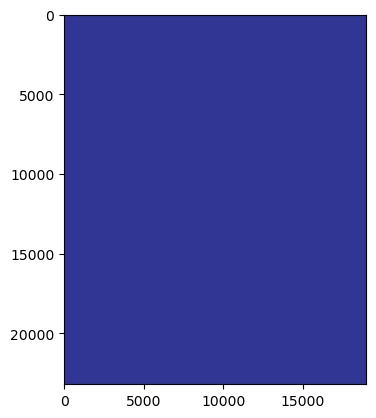

In [4]:
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tf.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 


# random.seed(555)
import time

# Record the start time
start_time = time.time()

#Overlap area parameter
area_perc = 0.99
#  Count background class
classNum=1

#  Training model storage address
ModelPath = "/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/nbac_mtbs.tf"

#  test data path
TifPath = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/for_local_predict/median_fp_175.tif'

# narray_norm = rioxarray.open_rasterio(TifPath)
# narray = rioxarray.open_rasterio(TifPath).to_numpy()

# narray = narray / 1000

# narray_norm.data = narray

# narray_norm.rio.to_raster('/explore/nobackup/people/spotter5/cnn_mapping/Russia/for_local_predict/median_divided_154.tif')

TifPath = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/for_local_predict/median_fp_175.tif'


#  Results save path
ResultPath = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/Russia/test_pred'
os.makedirs(ResultPath, exist_ok = True)

# train_label_path="./dataset/train/label"

RepetitiveLength = int((1 - math.sqrt(area_perc)) * 128 / 2)
RepetitiveLength  = 40

# files=os.listdir(TifPath)
# for i,file in enumerate(files):
im_width, im_height, im_bands, im_data, im_geotrans, im_proj = readTif(TifPath)

im_data= my_norm(im_data)


TifArray, RowOver, ColumnOver = TifCroppingArray(im_data, RepetitiveLength) #TifArray is where 25 is coming from, it is 5x5.  25 sub images in this case

flat_list = [
    x
    for xs in TifArray
    for x in xs
]

# testGene = testGenerator(flat_list) #make generator, used to be TifArray if not flat
# results = model.predict_generator(testGene,
#                                   len(TifArray) * len(TifArray[0]),
#                                   verbose = 0)

testGene = generator(flat_list) #make generator, used to be TifArray if not flat

results = np.array(model.predict_generator(testGene,
                                  45,
                                  verbose = 0))[0, :, :, :, :]
# #Save results
result_shape = (im_data.shape[0], im_data.shape[1])
result_data = Result(result_shape, TifArray, results, 2, RepetitiveLength, RowOver, ColumnOver)

# Record the end time
end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time_seconds = end_time - start_time

# Convert elapsed time to hours
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Elapsed time: {elapsed_time_hours:.2f} hours")

plt.imshow(result_data,  vmin = 0, vmax =  1.0, cmap = 'RdYlBu_r')

# thresholded = result_data.copy()
# thresholded[thresholded <0.5] = np.nan
# thresholded[np.isnan(thresholded) == False] = 1

# dnbr = im_data[:, :, 0]

# # Create a 2x2 subplot
# fig, axs = plt.subplots(2, 2, figsize=(10, 11))

# # Plot y
# axs[0, 0].imshow(y)
# axs[0, 0].set_title('Reference MTBS')

# # Plot dnbr
# axs[0, 1].imshow(dnbr, vmin = 0, vmax =  0.6, cmap = 'RdYlBu_r')
# axs[0, 1].set_title('dnbr')

# # Plot result_data
# axs[1, 0].imshow(result_data, cmap='viridis')
# axs[1, 0].set_title('Predicted')

# # Plot thresholded
# axs[1, 1].imshow(thresholded, cmap='viridis')
# axs[1, 1].set_title('Predicted Thresholded')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

# TifPath

In [ ]:
't'

In [33]:
#convert to band last
im_data = np.moveaxis(im_data, 0, 2) 
            
im_data.shape

(23203, 18981, 3)

/tmp/ipykernel_3259074/4195064006.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = np.array(model.predict_generator(testGene,


Elapsed time: 0.05 hours


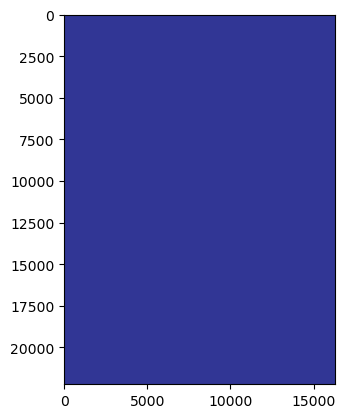

In [12]:

TifArray, RowOver, ColumnOver = TifCroppingArray(im_data, RepetitiveLength) #TifArray is where 25 is coming from, it is 5x5.  25 sub images in this case

flat_list = [
    x
    for xs in TifArray
    for x in xs
]

# testGene = testGenerator(flat_list) #make generator, used to be TifArray if not flat
# results = model.predict_generator(testGene,
#                                   len(TifArray) * len(TifArray[0]),
#                                   verbose = 0)

testGene = generator(flat_list) #make generator, used to be TifArray if not flat

results = np.array(model.predict_generator(testGene,
                                  45,
                                  verbose = 0))[0, :, :, :, :]
# #Save results
result_shape = (im_data.shape[0], im_data.shape[1])
result_data = Result(result_shape, TifArray, results, 2, RepetitiveLength, RowOver, ColumnOver)

# Record the end time
end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time_seconds = end_time - start_time

# Convert elapsed time to hours
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Elapsed time: {elapsed_time_hours:.2f} hours")

plt.imshow(result_data,  vmin = 0, vmax =  1.0, cmap = 'RdYlBu_r')

In [38]:
np.nanmax(result_data)

0.05677773

In [39]:
np.nanmax(im_data)

1.0

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)

min_max = min_max[['6', '7', '8']]

min_max

,6,7,8
0,21.0,-68.0,-9.0
1,974.0,522.0,686.0


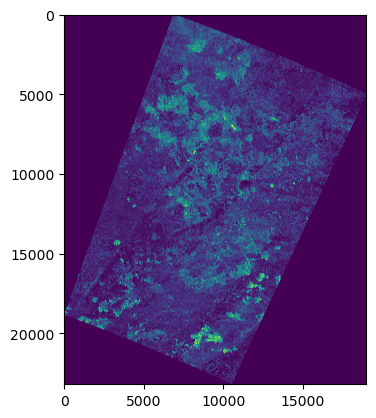

In [5]:
#  test data path
TifPath = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/for_local_predict/median_fp_175.tif'

narray_norm = rioxarray.open_rasterio(TifPath)
narray = rioxarray.open_rasterio(TifPath).to_numpy()

plt.imshow(narray[0, :, :], vmin = 0, vmax = 1000)

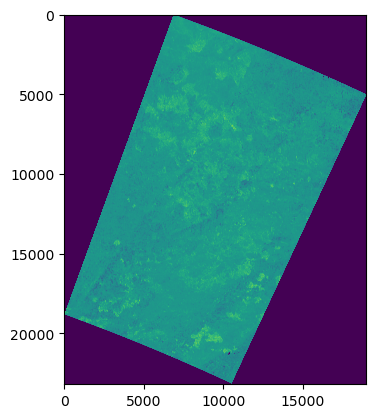

In [36]:
im_data[im_data == -1] = np.nan
plt.imshow(im_data[:, :, 0], vmin =  0, vmax= 1)

(array([[2.3199e+04, 0.0000e+00, 0.0000e+00, ..., 3.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.3196e+04, 0.0000e+00, 0.0000e+00, ..., 6.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.3194e+04, 0.0000e+00, 0.0000e+00, ..., 9.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.3195e+04, 0.0000e+00, 0.0000e+00, ..., 8.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3197e+04, 0.0000e+00, 0.0000e+00, ..., 6.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3201e+04, 0.0000e+00, 0.0000e+00, ..., 2.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 18981 BarContainer objects>)

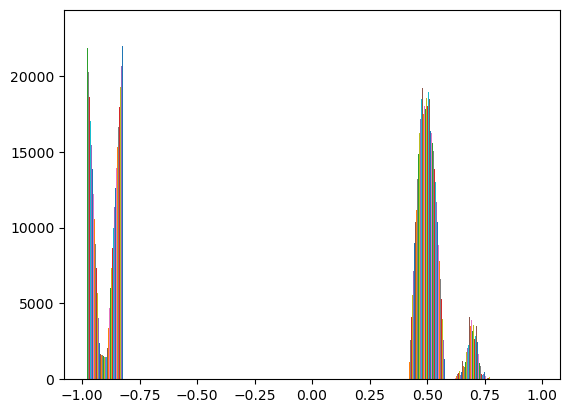

In [47]:
plt.hist(im_data[:, :, 0])

In [37]:
im_data[:, :, 0][0, 1]

-1.0

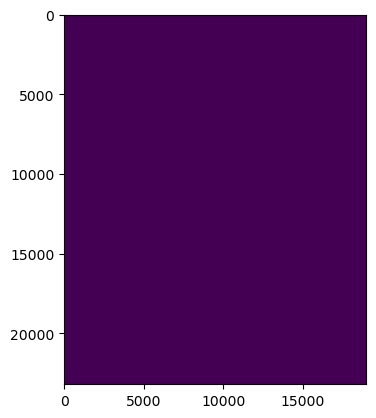

In [41]:
plt.imshow(result_data)